(week4:clip_bands)=
# Clipping multiple bands

## Introduction

We are going to need to look at bands 2, 3, 4, 5, 9, 10 and 11.  This notebook uses the clipped band we wrote in
{ref}`week3:image_zoom` to get the clipping box, then reads in each of these bands, clips to the same box and scales them,
and writes them out to new smaller geotifs.

- Download clip_bands.ipynb from the [week4 folder](https://drive.google.com/drive/folders/1-Ja2wVKVIjkZb7Gx_rfc14J_aBYiknuw?usp=sharing)
- You'll also need to copy the 5 tif files in the [vancouver](https://drive.google.com/drive/folders/1UwTc4MnneI2eZ6rHqKFzF4YdRRbQi4sS?usp=sharing) folder into a new folder on your drive called `~/repos/a301/satdata/landsat/vancouver`

In [1]:
import copy
import pprint
from pathlib import Path
from osgeo import gdal
import json

import cartopy
import numpy as np
import numpy.random
import rasterio
from affine import Affine
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from pyproj import CRS, Transformer
import rioxarray
from cartopy import crs as ccrs

## Get the original hls tif files from disk

This cell finds all the 3660 x 3660 landsat tifs we downloaded in the satdata/landsat/vancouver folder.  We can use the `*` wildcard
so we don't have to type in long filenames, and the `**` wildcard so we look in all subfolders.  If you're interested  here's
the [wikipedia entry on globbing](https://en.wikipedia.org/wiki/Glob_(programming)#:~:text=6%20References-,Origin,command%3A%20%2Fetc%2Fglob.)

In [2]:
data_dir = Path().home() / 'repos/a301/satdata/landsat'
the_tifs = list(data_dir.glob('**/HLS.L30*tif'))
print(the_tifs)

[PosixPath('/Users/phil/repos/a301/satdata/landsat/HLS.L30.T10UDV.2015165T190019.v2.0.B04.tif'), PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver/HLS.L30.T10UDV.2015165T190019.v2.0.B03.tif'), PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver/HLS.L30.T10UDV.2015165T190019.v2.0.B02.tif'), PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver/HLS.L30.T10UDV.2015165T190019.v2.0.B11.tif'), PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver/HLS.L30.T10UDV.2015165T190019.v2.0.B10.tif'), PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver/HLS.L30.T10UDV.2015165T190019.v2.0.B09.tif')]


## Examine the geotif metadata

### Using gdalinfo from the terminal

It turns out that rioxarray only copies part of the metadata into the `DataArray`.  To get all the metadata, we can use the underlying [gdal module](https://gdal.org/en/stable/programs/gdalinfo.html). Do the following:

- open a terminal
- cd to the folder holding the geotiff
- type `gdalinfo your_tif_name_here.tif`


### Using the python gdal api

We can also do that from inside python.  To get all the information for the first tif, do:

In [3]:
info = gdal.Info(the_tifs[1], format='json')
print(f"{type(info)=}")
info

type(info)=<class 'dict'>


/Users/phil/mini310/envs/a301/lib/python3.13/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


{'description': '/Users/phil/repos/a301/satdata/landsat/vancouver/HLS.L30.T10UDV.2015165T190019.v2.0.B03.tif',
 'driverShortName': 'GTiff',
 'driverLongName': 'GeoTIFF',
 'files': ['/Users/phil/repos/a301/satdata/landsat/vancouver/HLS.L30.T10UDV.2015165T190019.v2.0.B03.tif'],
 'size': [3660, 3660],
 'coordinateSystem': {'wkt': 'PROJCRS["UTM Zone 10, Northern Hemisphere",\n    BASEGEOGCRS["Unknown datum based upon the WGS 84 ellipsoid",\n        DATUM["Not specified (based on WGS 84 spheroid)",\n            ELLIPSOID["WGS 84",6378137,298.257223563,\n                LENGTHUNIT["metre",1],\n                ID["EPSG",7030]]],\n        PRIMEM["Greenwich",0,\n            ANGLEUNIT["degree",0.0174532925199433,\n                ID["EPSG",9122]]]],\n    CONVERSION["Transverse Mercator",\n        METHOD["Transverse Mercator",\n            ID["EPSG",9807]],\n        PARAMETER["Latitude of natural origin",0,\n            ANGLEUNIT["degree",0.0174532925199433],\n            ID["EPSG",8801]],\n     

### Dump all the metadata

You can print the  `info` dictionary to see the full gdal metadata dictionary.
Scanning through it, will see that the `metadata` key has two sub-keys:

In [4]:
print(f"{info['metadata'].keys()=}")

info['metadata'].keys()=dict_keys(['', 'IMAGE_STRUCTURE'])


And looking at the first key shows all of the metadata that rioxarray transfers to the DataArray attributes.  these are the entries that we'll need to change for our clipped, scaled image.  We need to change `NCOLS, NROWS, ULX, ULY and scale_factor` when we write the clipped geotif.  Descriptions of each of the metadata items are in the [hls user guide](https://lpdaac.usgs.gov/documents/1007/HLS_User_Guide_V15_provisional.pdf)

In [5]:
print(f"{info['metadata'][''].keys()=}")

info['metadata'][''].keys()=dict_keys(['ACCODE', 'add_offset', 'arop_ave_xshift(meters)', 'arop_ave_yshift(meters)', 'arop_ncp', 'arop_rmse(meters)', 'arop_s2_refimg', 'cloud_coverage', 'HLS_PROCESSING_TIME', 'HORIZONTAL_CS_NAME', 'L1_PROCESSING_TIME', 'LANDSAT_PRODUCT_ID', 'LANDSAT_SCENE_ID', 'long_name', 'MEAN_SUN_AZIMUTH_ANGLE', 'MEAN_SUN_ZENITH_ANGLE', 'MEAN_VIEW_AZIMUTH_ANGLE', 'MEAN_VIEW_ZENITH_ANGLE', 'NBAR_SOLAR_ZENITH', 'NCOLS', 'NROWS', 'OVR_RESAMPLING_ALG', 'PROCESSING_LEVEL', 'scale_factor', 'SENSING_TIME', 'SENSOR', 'SENTINEL2_TILEID', 'spatial_coverage', 'SPATIAL_RESOLUTION', 'TIRS_SSM_MODEL', 'TIRS_SSM_POSITION_STATUS', 'ULX', 'ULY', 'USGS_SOFTWARE', '_FillValue', 'AREA_OR_POINT'])


We want to check the `long_name` key in particular, to make sure we are looking at the right wavelength:

In [6]:
print(f"{info['metadata']['']['long_name']=}")

info['metadata']['']['long_name']='Green'


The exact wavelength range for each hls landsat band is given in the [spectral band table](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/#hls-spectral-bands)

## Read the bands into a dictionary and scale

We're ready to read all of the bands into a dictionary, keyed by the band `long_name`.  All the band names are listed in the
[spectral band table](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/#hls-spectral-bands). Note one complication -- the `unit` attribute is only present for brightness temperatures, not reflectivities.

Two notes on the next cell:

1. We use the `*=` assignment operator.  This is preferred because
   `a *= 5` is more concise than `a = a*5` and you don't risk making a typo on the second `a`
2. We use `hls_band.data *= hls_band.scale_factor` instead of `hls_band *= hls_band.scale_factor`.  The second version
   converts the result into a plain numpy array and overwrites the xarray, losing all the attributes
3. Because we set `masked=True`, all `-9999` values are changed to `np.nan` and `_FillValue` is deleted from
   the attributes.  That means we can multiply the data by the scale factor and not worry about the changed missing value.

In [7]:
band_dict={}
for tif_path in the_tifs:
    hls_band = rioxarray.open_rasterio(tif_path,masked=True)
    band_name = hls_band.long_name
    #
    # multiply the data by the scale factor
    #
    #  hls_band.data *= hls_band.scale_factor
    print(f"{band_name=}")
    band_dict[band_name] = hls_band
    if 'unit' in hls_band.attrs:
        print(f"{hls_band.unit=}")

band_name='Red'
band_name='Green'
band_name='Blue'
band_name='TIRS2'
hls_band.unit='Celsius'
band_name='TIRS1'
hls_band.unit='Celsius'
band_name='Cirrus'


## Read the clipped week3 band 5 file

Next we want to get the affine transform from week 3 clipped band file, so we can set the same bounding box for all tifs

### Create the bounding box using the upper left and lower right corners

This should be identical to the bounding box we found in {ref}`zoom_landsat_array`, which was:

`bounding_box=(476100.0, 5447460.0, 488100.0, 5465460.0)`

We can get them using the clipped affine transform.  Again, we search for the file using wild cards.  We just want
the first file we find, which means we need convert the python generator returned by glob into a list we can index.

In [8]:
filename =  list(data_dir.glob('**/band5_clipped*'))[0]
print(filename)
clipped_5 = rioxarray.open_rasterio(filename,masked=True)
clipped_transform = clipped_5.rio.transform()
clipped_transform

/Users/phil/repos/a301/satdata/landsat/band5_clipped_rio.tif


Affine(30.0, 0.0, 476100.0,
       0.0, -30.0, 5465460.0)

In [9]:
band, nrows, ncols = clipped_5.shape
nrows, ncols

(600, 400)

In [10]:
ul_x, ul_y = clipped_transform * (0, 0)
lr_x, lr_y = clipped_transform * (ncols, nrows)
bounding_box = (ul_x, lr_y, lr_x, ul_y)
print(f"{bounding_box=}")

bounding_box=(476100.0, 5447460.0, 488100.0, 5465460.0)


### Get the pyproj crs to copy to output tif

We want the improved crs we wrote out in {ref}`week3:image_zoom` for the band5 clipped tif, since  it includes the epsg code

In [11]:
good_crs = clipped_5.rio.crs
print(f"{good_crs.to_epsg()=}")

good_crs.to_epsg()=32610


## Clip the bands

Loop through the dictionary and clip each xarray.

In [12]:
for key, value in band_dict.items():
    band_dict[key] = value.rio.clip_box(*bounding_box)

## Check the brightness temperature in band 11

Text(0.5, 1.0, 'band TIRS2 (Celsius)')

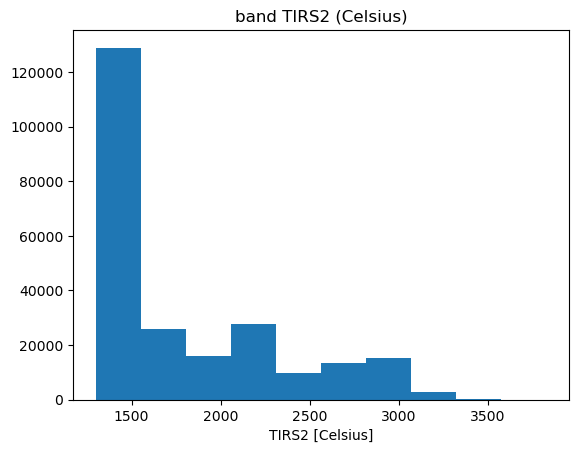

In [13]:
key = 'TIRS2'
fig, ax = plt.subplots(1,1)
band_dict[key].plot.hist(ax = ax)
ax.set_title(f"band {key} ({band_dict[key].unit})")

## Write the clipped geotiffs

Put these into the vancouver folder.  We can copy code from {ref}`week3:write_clipped`

### Transfer the crs and the affine transform

In [14]:
for key, value in band_dict.items():
    value.rio.write_crs(good_crs, inplace=True)
    value.rio.write_transform(clipped_transform, inplace=True)

### change some attributes

We need to adjust some of the attributions for the new subscene.  To do this, copy the exiting attributes into
a dictionary and rewrite the parts you want to change, adding any extras.

In [15]:
for key, value in band_dict.items():
    new_attrs = value.attrs
    new_attrs['ULX']= ul_x
    new_attrs['ULY'] = ul_y
    band, nrows, ncols = value.shape
    new_attrs['NROWS'] = nrows
    new_attrs['NCOLS'] = ncols
    new_attrs['scale_factor']=1.0
    new_attrs['FillValue'] = np.nan
    new_attrs['history'] = "written by the week4 clip_bands notebook"
    value.rio.update_attrs(new_attrs, inplace = True);

#### check the attributes

In [16]:
value.attrs['history']

'written by the week4 clip_bands notebook'

### Write out the new geotiffs 

We'll also add jpg files for browsing

In [17]:
for key, value in band_dict.items():
    band_name = value.long_name
    tif_filename = data_dir / 'vancouver' / f"week4_clipped_{band_name}.tif"
    #
    # remove the file if it already exists
    #
    if tif_filename.exists():
        tif_filename.unlink()
    value.rio.to_raster(tif_filename)

### read one back in to check

tif_filename=PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver/week4_clipped_TIRS1.tif')


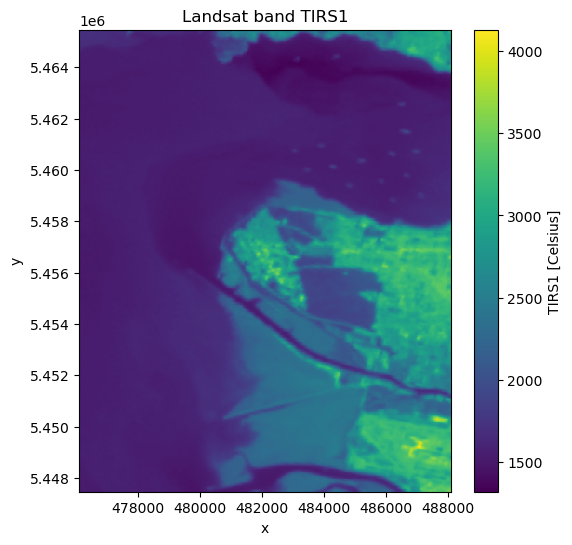

In [18]:
tif_filename = data_dir / 'vancouver' / f"week4_clipped_TIRS1.tif"
print(f"{tif_filename=}")
has_file = tif_filename.exists()
if not has_file:
    raise IOError(f"can't find {filename}, something went wrong above") 
small_band = rioxarray.open_rasterio(tif_filename,masked=True)
band_name = small_band.long_name
fig, ax = plt.subplots(1,1, figsize=(6,6))
small_band.plot(ax=ax)
ax.set_title(f"Landsat band {band_name}");

#### note that we now have the correct epsg code

Because we used the pyproj `good_crs` in our raster write we've fixed the missing epsg code problem.

In [19]:
small_band.rio.crs.to_epsg()

32610

In [20]:
help(CRS)

Help on class CRS in module pyproj.crs.crs:

class CRS(builtins.object)
 |  CRS(projparams: typing.Any | None = None, **kwargs) -> None
 |
 |  A pythonic Coordinate Reference System manager.
 |
 |  .. versionadded:: 2.0.0
 |
 |  See: :c:func:`proj_create`
 |
 |  The functionality is based on other fantastic projects:
 |
 |  * `rasterio <https://github.com/mapbox/rasterio/blob/c13f0943b95c0eaa36ff3f620bd91107aa67b381/rasterio/_crs.pyx>`_  # noqa: E501
 |  * `opendatacube <https://github.com/opendatacube/datacube-core/blob/83bae20d2a2469a6417097168fd4ede37fd2abe5/datacube/utils/geometry/_base.py>`_  # noqa: E501
 |
 |  Attributes
 |  ----------
 |  srs: str
 |      The string form of the user input used to create the CRS.
 |
 |  Methods defined here:
 |
 |  __eq__(self, other: Any) -> bool
 |      Return self==value.
 |
 |  __getstate__(self) -> dict[str, str]
 |      Helper for pickle.
 |
 |  __hash__(self) -> int
 |      Return hash(self).
 |
 |  __init__(self, projparams: typing.Any |

In [21]:
small_band.transform

AttributeError: 'DataArray' object has no attribute 'transform'

In [ ]:
small_band.rio.transform()